<a href="https://colab.research.google.com/github/AshenWitch96/Zelestra-X-AWS-ML-Ascend-Challenge---2nd-Edition/blob/main/Zelestra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training

# Step 1: Installing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Step 2:  Load and Clean Training Data (train.csv)

In [ ]:
# Load the training dataset
train_data = pd.read_csv('train.csv')

print("Train dataset shape:", train_data.shape)
print("\nMissing values before cleaning:")
print(train_data.isnull().sum())

# Convert potential numeric columns to proper numeric types
potentially_numerical_cols = [
    'temperature', 'irradiance', 'humidity', 'panel_age',
    'maintenance_count', 'soiling_ratio', 'voltage', 'current',
    'module_temperature', 'cloud_coverage', 'wind_speed',
    'pressure', 'efficiency'
]

for col in potentially_numerical_cols:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')

# Fill missing values with median
for col in potentially_numerical_cols:
    train_data[col] = train_data[col].fillna(train_data[col].median())

# Handle categorical values
train_data['error_code'] = train_data['error_code'].replace('error', np.nan)
categorical_cols = ['error_code', 'installation_type', 'string_id']
for col in categorical_cols:
    mode_val = train_data[col].mode()
    train_data[col] = train_data[col].fillna(mode_val[0] if not mode_val.empty else 'missing')

print("\nMissing values after cleaning:")
print(train_data.isnull().sum())

Train dataset shape: (20000, 17)

Missing values before cleaning:
id                       0
temperature           1001
irradiance             987
humidity                 0
panel_age             1011
maintenance_count     1027
soiling_ratio         1010
voltage                993
current                977
module_temperature     978
cloud_coverage        1010
wind_speed               0
pressure                 0
string_id                0
error_code            5912
installation_type     5028
efficiency               0
dtype: int64

Missing values after cleaning:
id                    0
temperature           0
irradiance            0
humidity              0
panel_age             0
maintenance_count     0
soiling_ratio         0
voltage               0
current               0
module_temperature    0
cloud_coverage        0
wind_speed            0
pressure              0
string_id             0
error_code            0
installation_type     0
efficiency            0
dtype: int64


# Step 3: Visualizations

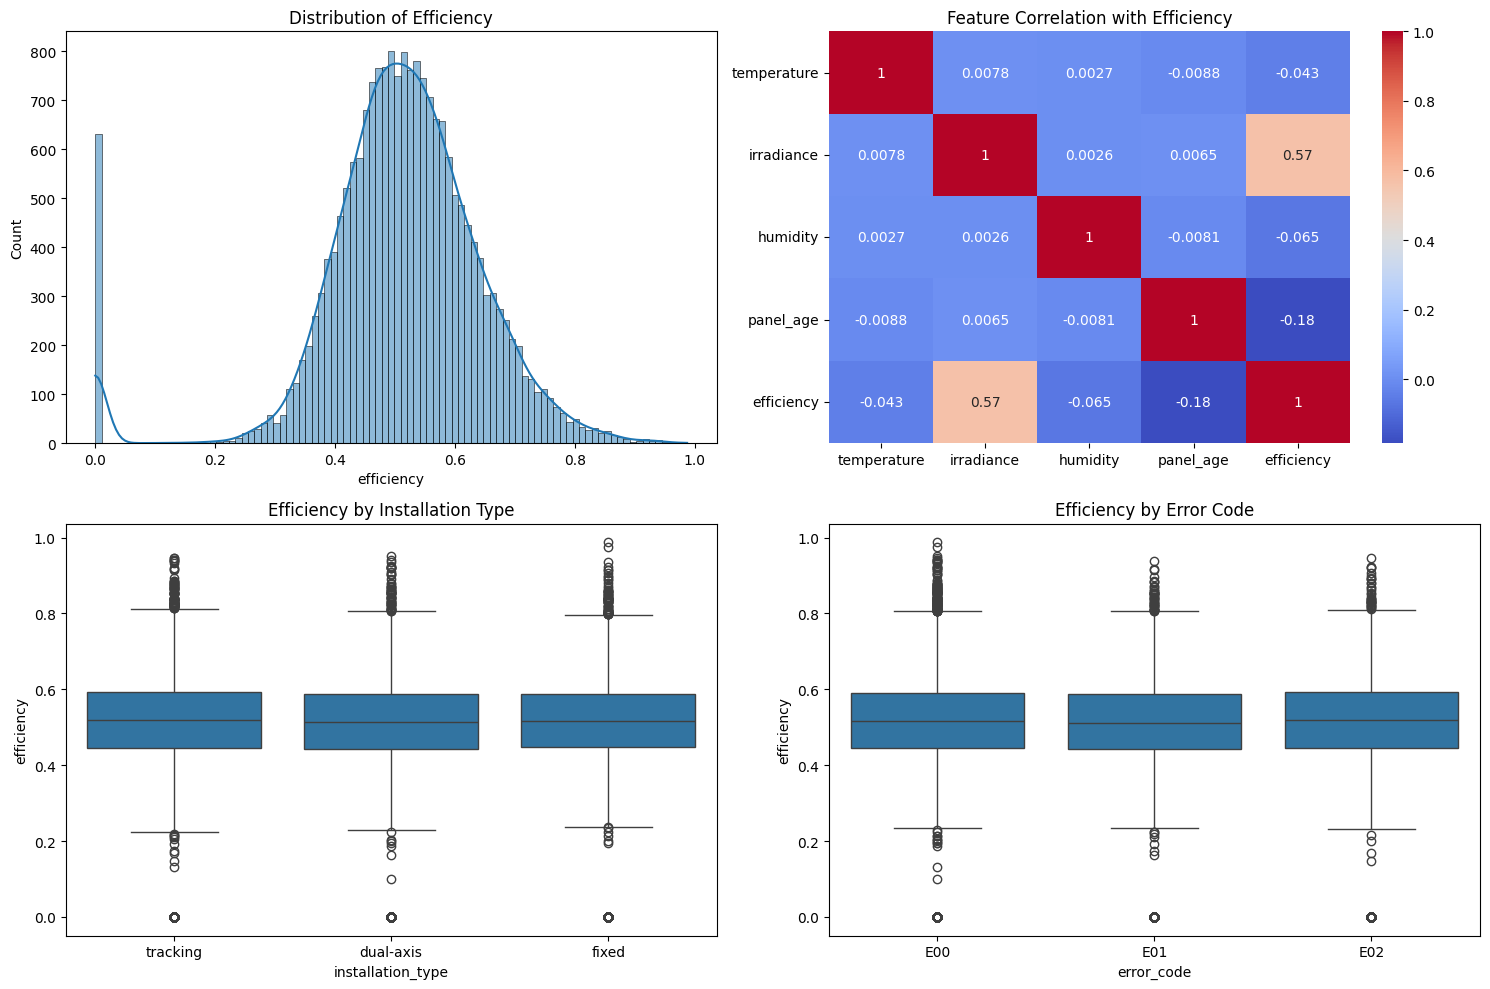

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(train_data['efficiency'], kde=True)
plt.title('Distribution of Efficiency')

plt.subplot(2, 2, 2)
corr = train_data[['temperature', 'irradiance', 'humidity', 'panel_age', 'efficiency']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Efficiency')

plt.subplot(2, 2, 3)
sns.boxplot(x='installation_type', y='efficiency', data=train_data)
plt.title('Efficiency by Installation Type')

plt.subplot(2, 2, 4)
sns.boxplot(x='error_code', y='efficiency', data=train_data)
plt.title('Efficiency by Error Code')

plt.tight_layout()
plt.show()


# Step 4: Preprocessing & Feature Engineering

In [ ]:
def preprocess_data(df):
    df['power_output'] = df['voltage'] * df['current']
    df['temp_diff'] = df['module_temperature'] - df['temperature']
    df['age_maintenance_ratio'] = df['panel_age'] / (df['maintenance_count'] + 1)

    le = LabelEncoder()
    for col in ['string_id', 'error_code', 'installation_type']:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    return df

train_data = preprocess_data(train_data)


# Step 5: Split and Scale Data

In [ ]:
features = ['temperature', 'irradiance', 'humidity', 'panel_age', 'maintenance_count',
            'soiling_ratio', 'voltage', 'current', 'module_temperature', 'cloud_coverage',
            'wind_speed', 'pressure', 'string_id', 'error_code', 'installation_type',
            'power_output', 'temp_diff', 'age_maintenance_ratio']

target = 'efficiency'

X = train_data[features]
y = train_data[target]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Step 6:  Build & Train LSTM Model

In [ ]:
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Save the model in the native Keras format
model.save('best_model.keras')

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0540 - val_loss: 0.0130
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0122 - val_loss: 0.0124
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0110 - val_loss: 0.0117
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0108 - val_loss: 0.0115
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━

# Step 7: Training History Visualization

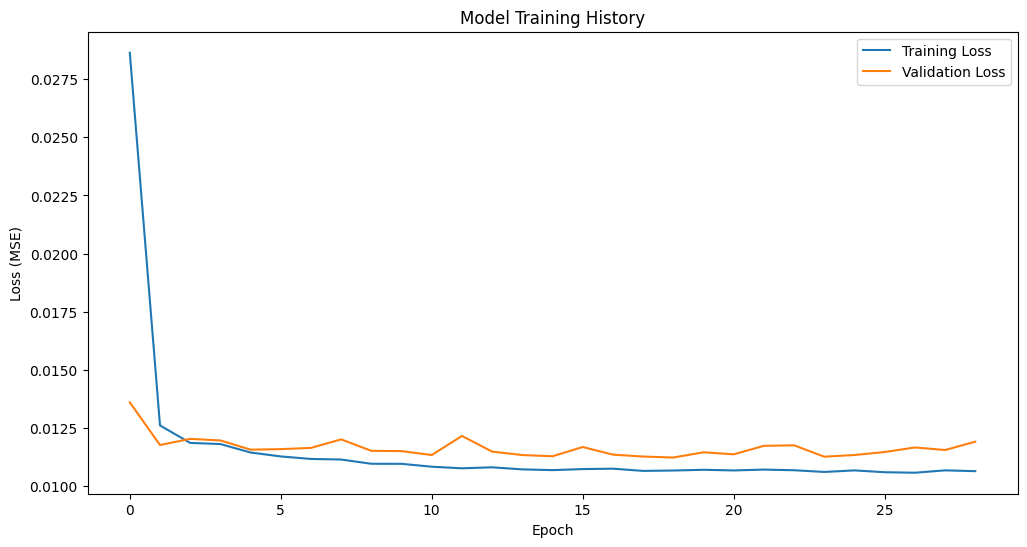

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Step 8:  Permutation Feature Importance

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

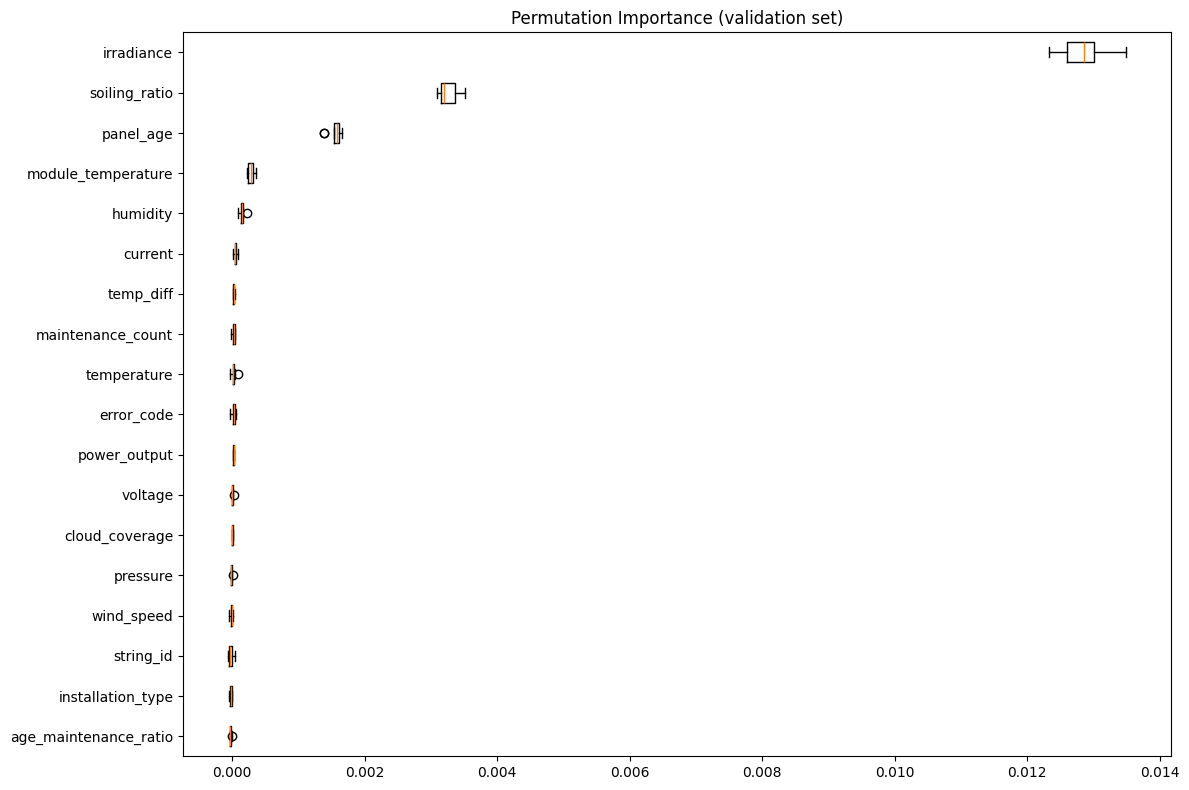

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

dnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[2],)),
    Dense(32, activation='relu'),
    Dense(1)
])
dnn_model.compile(optimizer='adam', loss='mse')
dnn_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train, epochs=20, verbose=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
result = permutation_importance(
    dnn_model,
    X_val.reshape(X_val.shape[0], X_val.shape[2]),
    y_val,
    scoring=scorer,
    n_repeats=10,
    random_state=42
)

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features)[sorted_idx])
plt.title("Permutation Importance (validation set)")
plt.tight_layout()
plt.show()

# Testing

# Step 1: Import libraries

In [ ]:
!pip install joblib
from sklearn.preprocessing import MinMaxScaler # Changed from StandardScaler
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder # Added LabelEncoder

#  Step 2: Load test data

In [ ]:
test_data = pd.read_csv('test.csv')
print("✅ Test data loaded. Shape:", test_data.shape)

#  Step 3: Define columns and load assets

In [ ]:
# These should match your training configuration
potentially_numerical_cols = ['voltage', 'current', 'temperature', 'module_temperature', 'panel_age', 'maintenance_count', 'irradiance', 'humidity', 'soiling_ratio', 'cloud_coverage', 'wind_speed', 'pressure'] # Added missing columns
categorical_cols = ['string_id', 'error_code', 'installation_type'] # Changed from location, panel_type
features = ['temperature', 'irradiance', 'humidity', 'panel_age', 'maintenance_count',
            'soiling_ratio', 'voltage', 'current', 'module_temperature', 'cloud_coverage',
            'wind_speed', 'pressure', 'string_id', 'error_code', 'installation_type',
            'power_output', 'temp_diff', 'age_maintenance_ratio'] # Updated features to match training

# Load scaler and model used during training
scaler = joblib.load('scaler.pkl')                # MinMaxScaler object (Changed from StandardScaler)
model = load_model('best_model.keras')               # Trained Keras model (Changed to .keras format)

# Define preprocessing function (as used during training)
def preprocess_data(df):
    df = df.copy()

    # Handle categorical values (using LabelEncoder as in training)
    le = LabelEncoder()
    for col in ['string_id', 'error_code', 'installation_type']: # Updated categorical columns
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str)) # Changed to fit_transform

    return df

#  Step 4: Clean test data

In [ ]:
# Convert specified columns to proper numeric types (as in training)
potentially_numerical_cols_clean = [
    'temperature', 'irradiance', 'humidity', 'panel_age',
    'maintenance_count', 'soiling_ratio', 'voltage', 'current',
    'module_temperature', 'cloud_coverage', 'wind_speed',
    'pressure'
]

for col in potentially_numerical_cols_clean:
    if col in test_data.columns:
        test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

# Fill missing values with median (as in training)
for col in potentially_numerical_cols_clean:
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(test_data[col].median())

# Handle categorical values (as in training)
if 'error_code' in test_data.columns:
    test_data['error_code'] = test_data['error_code'].replace('error', np.nan)

categorical_cols_clean = ['error_code', 'installation_type', 'string_id'] # Updated categorical columns
for col in categorical_cols_clean:
    if col in test_data.columns:
        mode_val = test_data[col].mode()
        test_data[col] = test_data[col].fillna(mode_val[0] if not mode_val.empty else 'missing')


print("✅ Data cleaning complete.")


#  Step 5: Preprocess the test data

In [ ]:
test_data = preprocess_data(test_data)
print("✅ Categorical preprocessing complete.")

# Step 6: Feature engineering

In [ ]:
# Create power_output = voltage * current
if 'power_output' not in test_data.columns:
    test_data['power_output'] = test_data['voltage'] * test_data['current']

# Create temp_diff = module_temperature - temperature
if 'temp_diff' not in test_data.columns:
    test_data['temp_diff'] = test_data['module_temperature'] - test_data['temperature']

# Create age_maintenance_ratio = panel_age / (test_data['maintenance_count'] + 1) # Corrected denominator
if 'age_maintenance_ratio' not in test_data.columns:
    test_data['age_maintenance_ratio'] = test_data['panel_age'] / (test_data['maintenance_count'] + 1)

print("✅ Feature engineering complete.")

✅ Feature engineering complete.


#  Final Step: Scale, reshape, predict, and save submission

In [ ]:
# Extract features and scale them
X_test = test_data[features]
X_test_scaled = scaler.transform(X_test)
print("✅ Feature scaling complete. Shape:", X_test_scaled.shape)

# Reshape for model (for CNN/RNN input)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print("✅ Reshaping complete. Shape:", X_test_reshaped.shape)

# Predict efficiency
predictions = model.predict(X_test_reshaped).flatten()
print("✅ Predictions made. First 5 predictions:", predictions[:5])

# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'efficiency': predictions
})

submission.to_csv('submission.csv', index=False)
print("✅ submission.csv created successfully. Shape:", submission.shape)

✅ Test data loaded. Shape: (12000, 16)
✅ Data cleaning complete.
✅ Categorical preprocessing complete.
✅ Feature engineering complete.
✅ Feature scaling complete. Shape: (12000, 18)
✅ Reshaping complete. Shape: (12000, 1, 18)
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Predictions made. First 5 predictions: [0.38263458 0.53975445 0.5212604  0.45546657 0.4757781 ]
✅ submission.csv created successfully. Shape: (12000, 2)
